In [6]:
import xgboost as xgb
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

with open(
    "/kaggle/input/vgg16-models-predictions-test-set/model_1_4_probabilities.pkl", "rb"
) as f_prob1:
    probabilities_1_4 = pickle.load(f_prob1)

with open(
    "/kaggle/input/vgg16-models-predictions-test-set/model_5_8_probabilities.pkl", "rb"
) as f_prob2:
    probabilities_5_8 = pickle.load(f_prob2)

with open(
    "/kaggle/input/vgg16-models-predictions-test-set/model_9_12_probabilities.pkl", "rb"
) as f_prob3:
    probabilities_9_12 = pickle.load(f_prob3)

all_probabilities = {**probabilities_1_4, **probabilities_5_8, **probabilities_9_12}

all_labels = []

In [7]:
from torch.utils.data import DataLoader, random_split
from dataset.dataset import PlanetaryDataset
from utilities.training import VAL_TEST_TRANSFORM

# Hard Voting (Majority Vote)
test_dataset = PlanetaryDataset(
    data_dir="/kaggle/input/gsoc-protoplanetary-disks/Test_Clean",
    csv_file="/kaggle/input/gsoc-protoplanetary-disks/test_info.csv",
    channels=list(range(30, 101)),
    transform=VAL_TEST_TRANSFORM,
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for i, batch in enumerate(test_loader):
    _, labels = batch
    all_labels.append(labels.item())

In [11]:
X_soft = np.array(
    [
        np.concatenate(
            [all_probabilities[model_path][i] for model_path in all_probabilities]
        )
        for i in range(len(all_labels))
    ]
)

# (num_samples, num_models * num_classes)
y = np.array(all_labels)

In [15]:
print(f"Shape of X (before reshaping): {X_soft.shape}")

Shape of X (before reshaping): (3621, 12, 2)


In [16]:
if len(X_soft.shape) != 2:
    X_soft = X_soft.reshape(X.shape[0], -1)

In [17]:
print(f"Shape of X (after reshaping): {X_soft.shape}")

Shape of X (after reshaping): (3621, 24)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_soft, y, test_size=0.3, random_state=42
)

In [14]:
for model_path, probs in all_probabilities.items():
    print(f"Shape of probabilities for model {model_path}: {np.array(probs).shape}")

Shape of probabilities for model /kaggle/input/vgg16-models/pytorch/default/2/model_channels_30_31_32_33_34_35.pt: (3621, 1, 2)
Shape of probabilities for model /kaggle/input/vgg16-models/pytorch/default/2/model_channels_36_37_38_39_40_41.pt: (3621, 1, 2)
Shape of probabilities for model /kaggle/input/vgg16-models/pytorch/default/2/model_channels_42_43_44_45_46_47.pt: (3621, 1, 2)
Shape of probabilities for model /kaggle/input/vgg16-models/pytorch/default/2/model_channels_48_49_50_51_52_53.pt: (3621, 1, 2)
Shape of probabilities for model /kaggle/input/vgg16-models/pytorch/default/2/model_channels_54_55_56_57_58_59.pt: (3621, 1, 2)
Shape of probabilities for model /kaggle/input/vgg16-models/pytorch/default/2/model_channels_60_61_62_63_64_65.pt: (3621, 1, 2)
Shape of probabilities for model /kaggle/input/vgg16-models/pytorch/default/2/model_channels_66_67_68_69_70_71.pt: (3621, 1, 2)
Shape of probabilities for model /kaggle/input/vgg16-models/pytorch/default/2/model_channels_72_73_74_75

## 1. XGBoost metalearner

In [19]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy (Soft Probas): {accuracy_xgb * 100:.2f}%")

incorrect_samples = np.where(y_pred != y_test)[0]
with open("incorrect_samples_xgboost.pkl", "wb") as f:
    pickle.dump(incorrect_samples, f)

XGBoost Accuracy (Soft Probas): 96.41%


In [20]:
xgb_model.save_model("xgboost_meta_learner_model.json")

#### Observe misclassified data

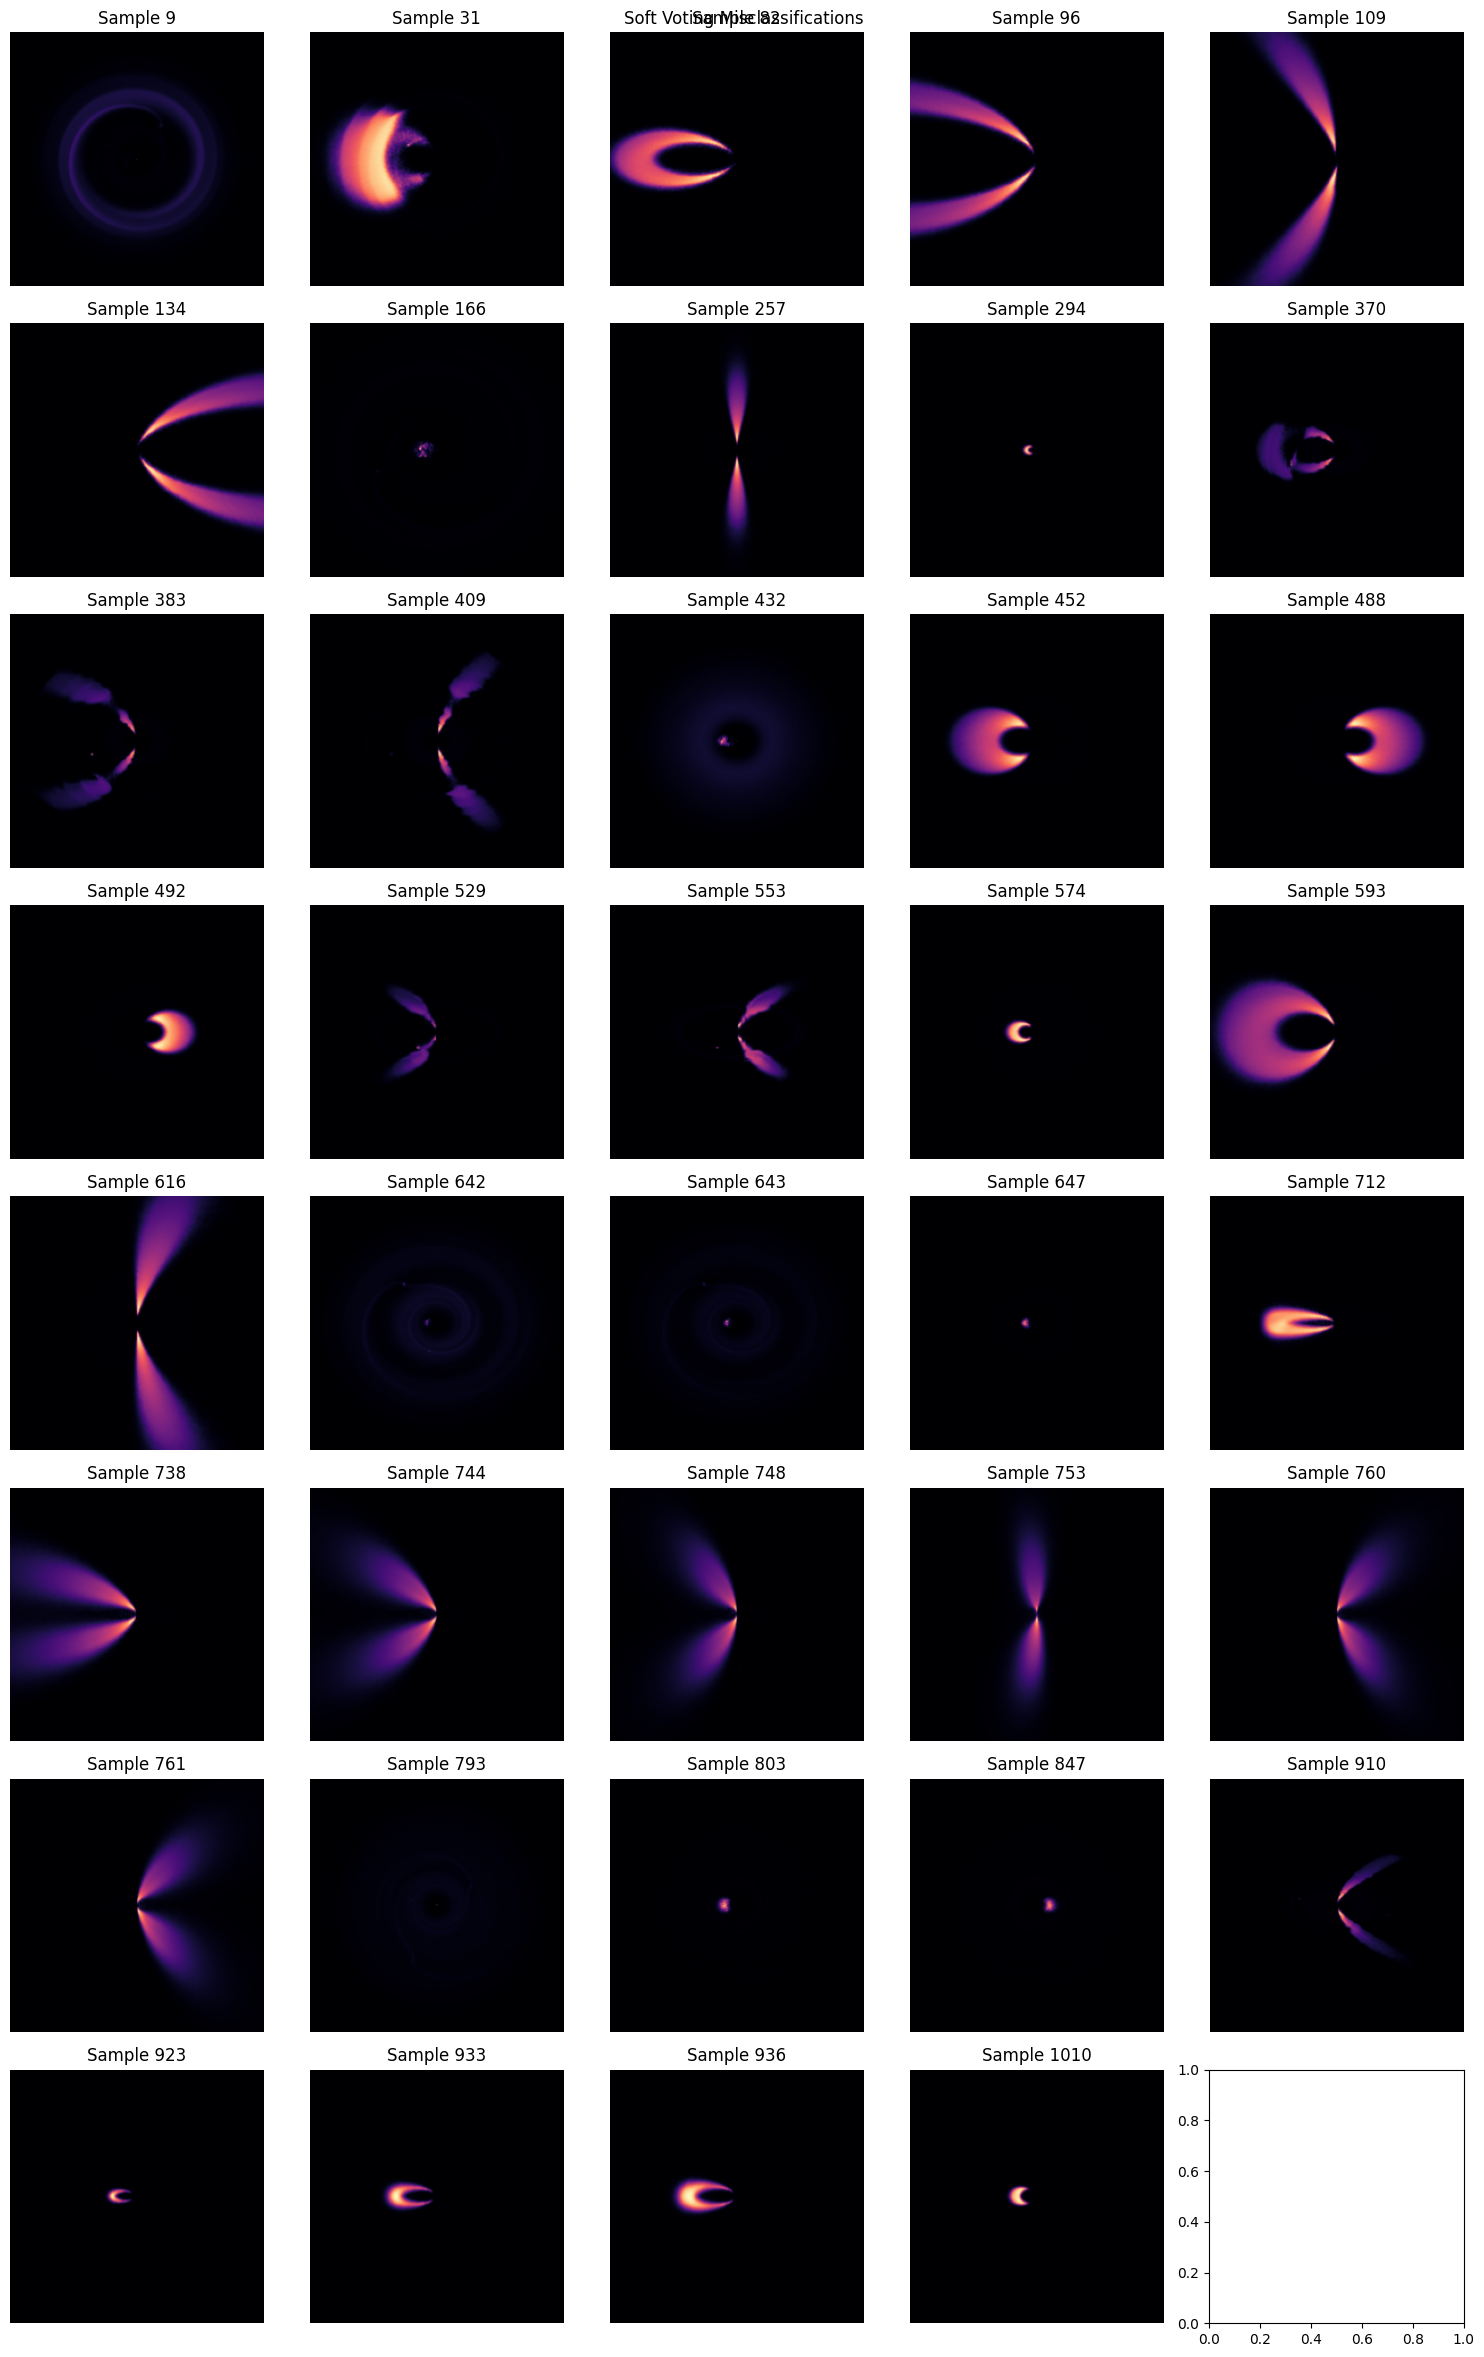

In [22]:
import matplotlib.pyplot as plt
import pickle

with open("/kaggle/working/incorrect_samples_xgboost.pkl", "rb") as f_soft:
    incorrect_samples_soft = pickle.load(f_soft)


def plot_images(dataset, indices, title, num_cols=5):
    num_rows = len(indices) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    for i, idx in enumerate(indices):
        image, _ = dataset[idx]
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Sample {idx}")
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


plot_images(test_dataset, incorrect_samples_soft, "Soft Voting Misclassifications")

## 2. LightGBM metalearner

In [23]:
!pip install lightgbm

In [24]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import numpy as np

lgb_model = lgb.LGBMClassifier(objective="binary", boosting_type="gbdt")
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

accuracy_lgb = accuracy_score(y_test, y_pred)
print(f"LightGBM Accuracy (Soft Probas): {accuracy_lgb * 100:.2f}%")

incorrect_samples = np.where(y_pred != y_test)[0]
with open("incorrect_samples_lightgbm.pkl", "wb") as f:
    pickle.dump(incorrect_samples, f)

lgb_model.booster_.save_model("lightgbm_meta_learner_model.txt")

[LightGBM] [Info] Number of positive: 2194, number of negative: 340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 2534, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.865825 -> initscore=1.864536
[LightGBM] [Info] Start training from score 1.864536
LightGBM Accuracy (Soft Probas): 96.87%


#### Observe misclassified data

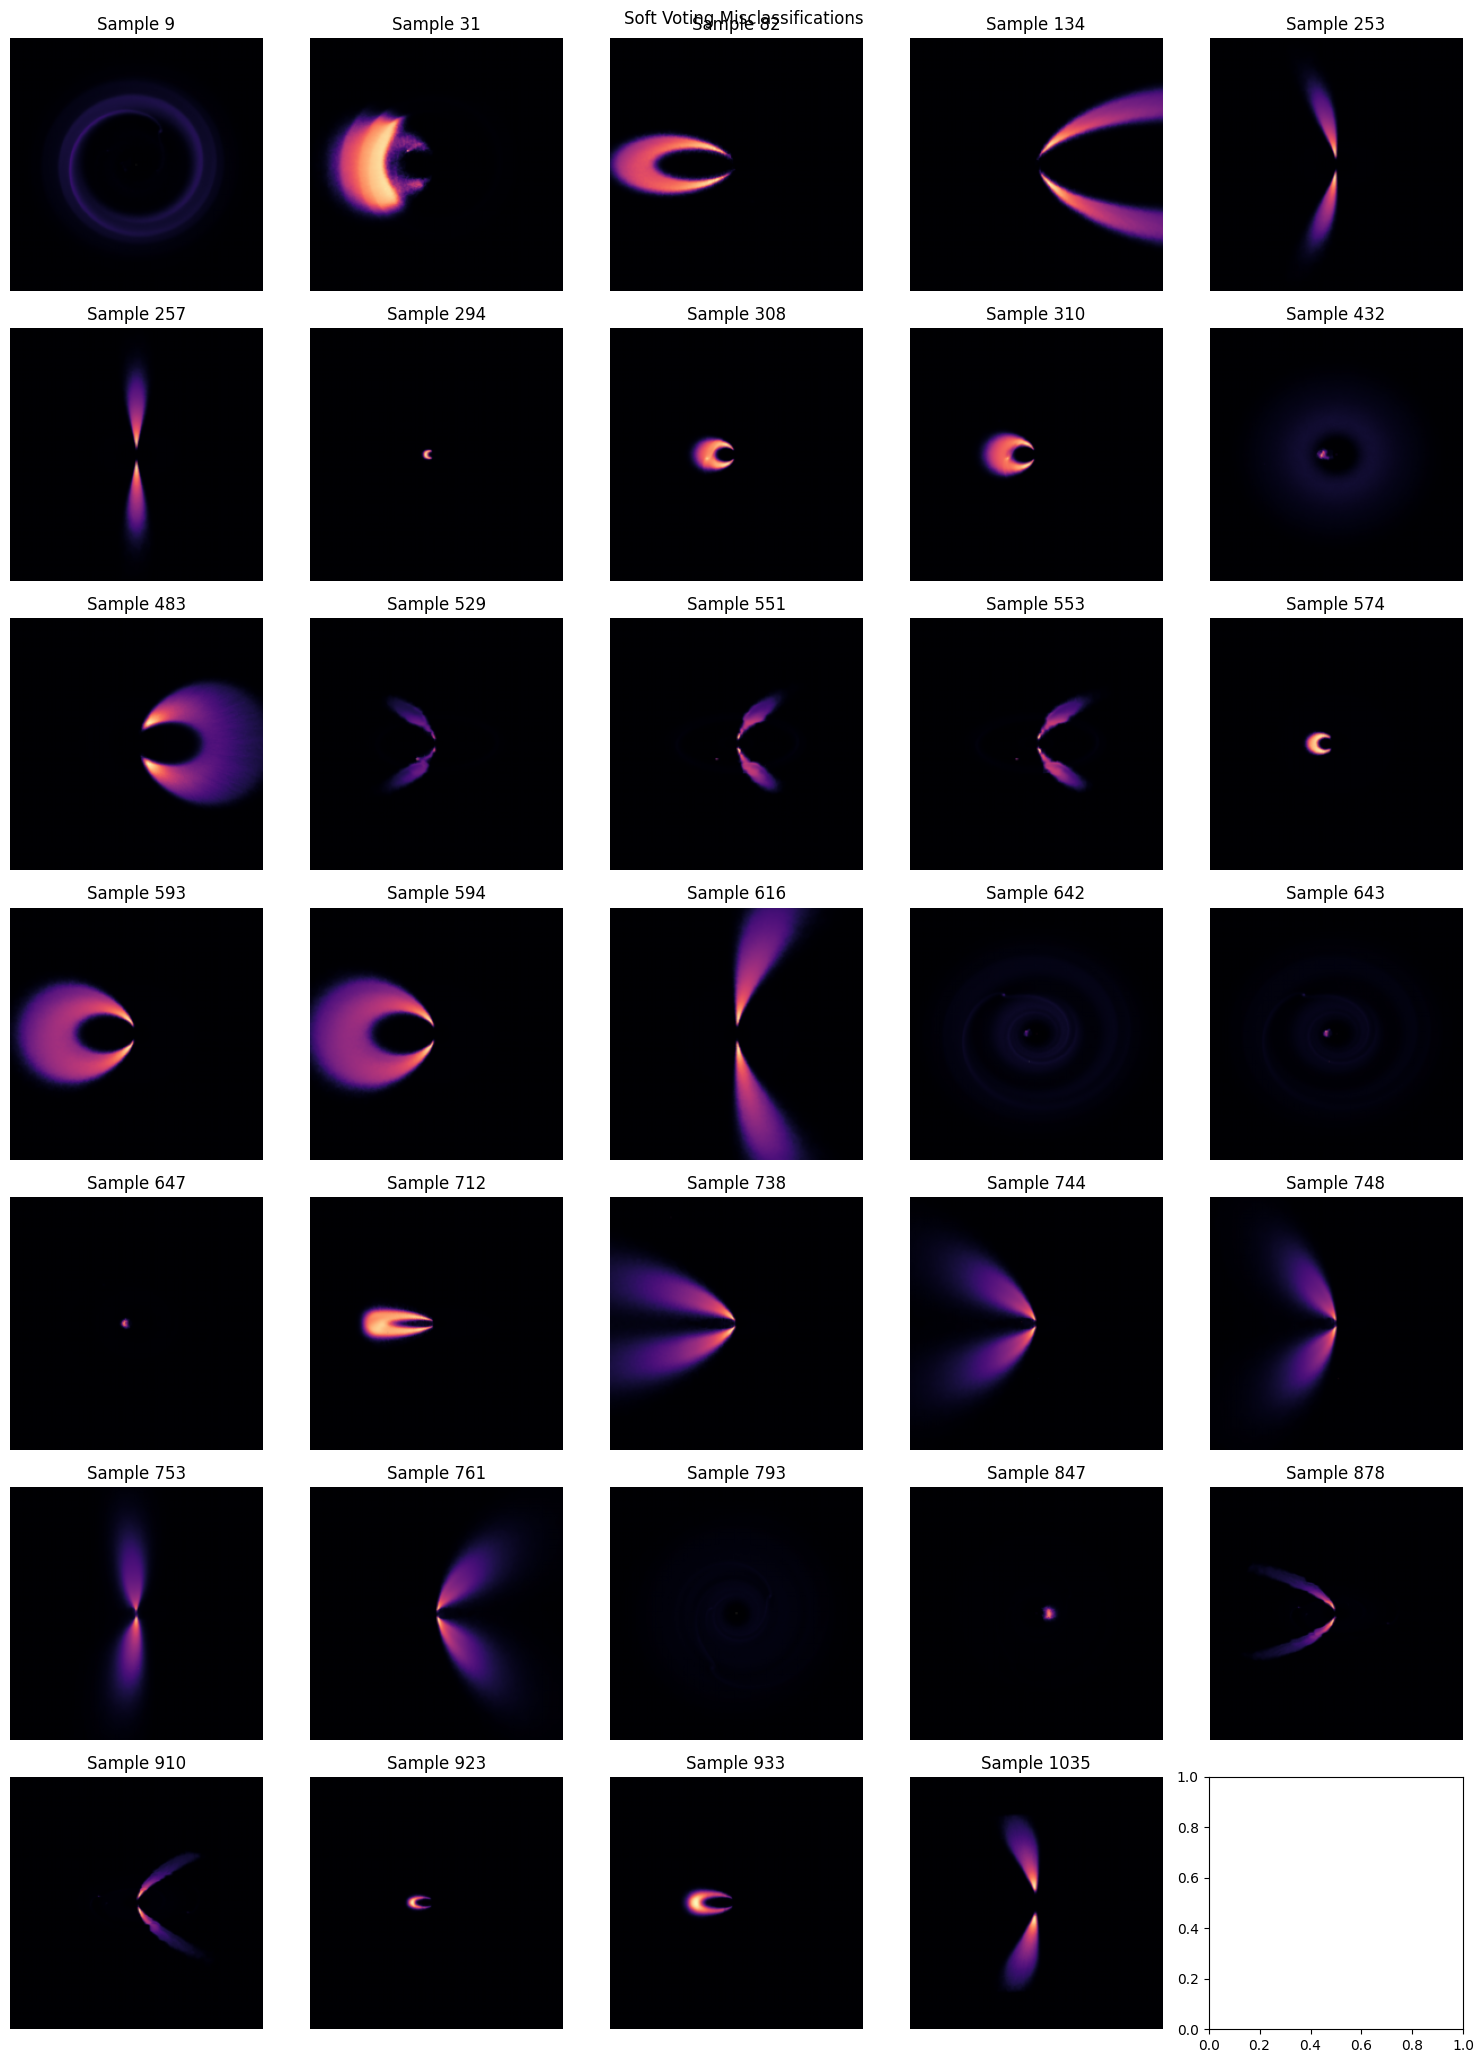

In [25]:
import matplotlib.pyplot as plt
import pickle

with open("/kaggle/working/incorrect_samples_lightgbm.pkl", "rb") as f_soft:
    incorrect_samples_soft = pickle.load(f_soft)


def plot_images(dataset, indices, title, num_cols=5):
    num_rows = len(indices) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    for i, idx in enumerate(indices):
        image, _ = dataset[idx]
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Sample {idx}")
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


plot_images(test_dataset, incorrect_samples_soft, "Soft Voting Misclassifications")

## 3. CatBoost metalearner

In [26]:
!pip install catboost

In [27]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import numpy as np

catboost_model = CatBoostClassifier(verbose=0)
catboost_model.fit(X_train, y_train)

y_pred = catboost_model.predict(X_test)

accuracy_catboost = accuracy_score(y_test, y_pred)
print(f"CatBoost Accuracy (Soft Probas): {accuracy_catboost * 100:.2f}%")

incorrect_samples = np.where(y_pred != y_test)[0]
with open("incorrect_samples_catboost.pkl", "wb") as f:
    pickle.dump(incorrect_samples, f)

catboost_model.save_model("catboost_meta_learner_model.cbm")

CatBoost Accuracy (Soft Probas): 96.60%


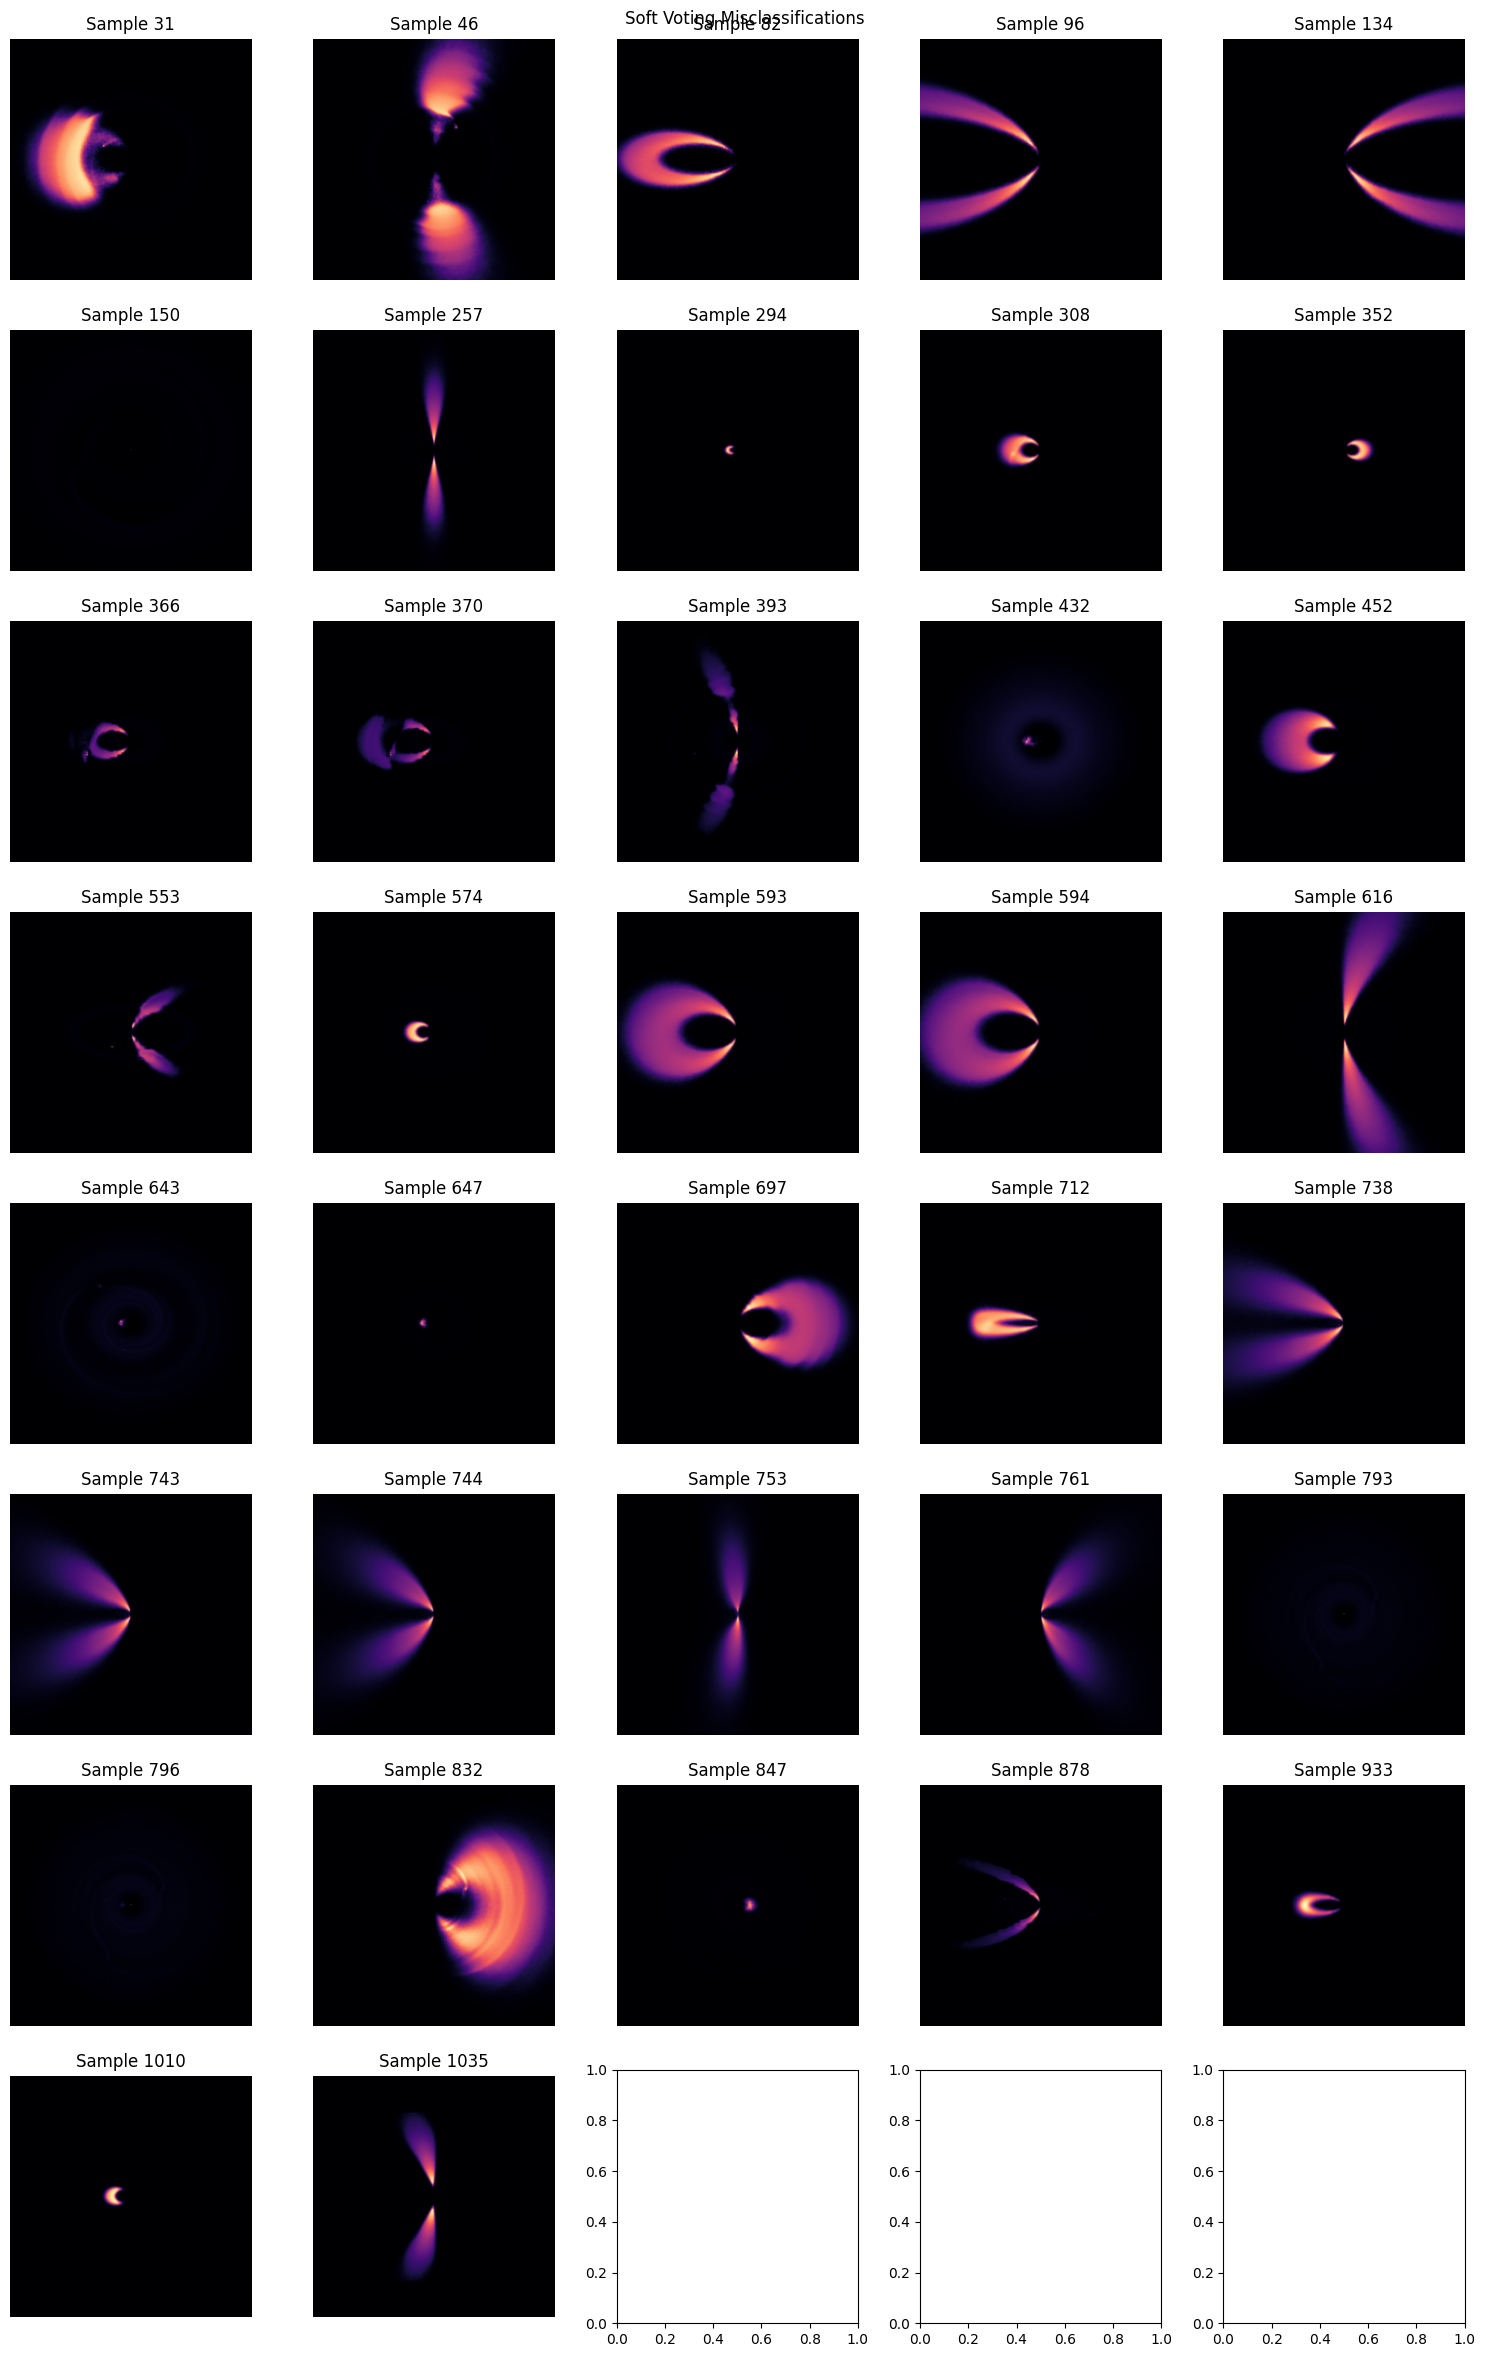

In [28]:
import matplotlib.pyplot as plt
import pickle

with open("/kaggle/working/incorrect_samples_catboost.pkl", "rb") as f_soft:
    incorrect_samples_soft = pickle.load(f_soft)


def plot_images(dataset, indices, title, num_cols=5):
    num_rows = len(indices) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    for i, idx in enumerate(indices):
        image, _ = dataset[idx]
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Sample {idx}")
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


plot_images(test_dataset, incorrect_samples_soft, "Soft Voting Misclassifications")